In [1]:
from glob import glob
import pandas as pd
from dask import dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_csv_files = glob('*.csv')

In [3]:
unique_errors = np.unique([x.split('_')[-1][:-4] for x in all_csv_files])
num_interactions = [f'numInteractions_{x}' for x in [2,5, 7, 10]]
sample_sizes = [f"n_{x}" for x in [500, 1_000, 5_000, 10_000]]

In [4]:
from itertools import product
from collections import defaultdict
grouped_files = defaultdict(list)
for i, u in product(num_interactions, unique_errors):
    search = glob(f'*_{i}_*n_500_*_{u}.csv')
    if len(search):
        grouped_files[f"{i}_{u}_500"] += search
    search =  glob(f'*_{i}_*n_1000_*_{u}.csv')
    if len(search):
        grouped_files[f"{i}_{u}_1000"] += search



In [5]:
unique_errors

array(['1', '1.4142135623730951', '2.23606797749979',
       '3.1622776601683795'], dtype='<U18')

In [6]:
list(grouped_files.keys())

['numInteractions_2_1_500',
 'numInteractions_2_1_1000',
 'numInteractions_2_1.4142135623730951_500',
 'numInteractions_2_1.4142135623730951_1000',
 'numInteractions_2_2.23606797749979_500',
 'numInteractions_2_2.23606797749979_1000',
 'numInteractions_2_3.1622776601683795_500',
 'numInteractions_5_1_500',
 'numInteractions_5_1_1000',
 'numInteractions_5_1.4142135623730951_500',
 'numInteractions_5_1.4142135623730951_1000',
 'numInteractions_5_2.23606797749979_500',
 'numInteractions_5_2.23606797749979_1000',
 'numInteractions_5_3.1622776601683795_500',
 'numInteractions_5_3.1622776601683795_1000',
 'numInteractions_7_1_500',
 'numInteractions_7_1_1000',
 'numInteractions_7_1.4142135623730951_500',
 'numInteractions_7_1.4142135623730951_1000',
 'numInteractions_7_2.23606797749979_500',
 'numInteractions_7_2.23606797749979_1000',
 'numInteractions_7_3.1622776601683795_500',
 'numInteractions_10_1_500',
 'numInteractions_10_1_1000',
 'numInteractions_10_1.4142135623730951_500',
 'numInte

In [7]:
test = list(grouped_files.keys())[0]
file_list = grouped_files[test]
test

'numInteractions_2_1_500'

In [8]:
import pickle
i = test.split('_')[1]
with open(f'sample_generator_config_i_{i}.pickle', 'rb') as f:
    config= pickle.load(f)

In [9]:
for i, filepath in enumerate(file_list):
    ddf = dd.read_csv(filepath)
    columns = ddf.columns[ddf.columns.str.contains(',')].tolist() + ['score']
    ddf = ddf.loc[:, columns].sort_values(['score'], ascending = False).reset_index(drop = True)
    ddf = ddf.loc[ddf.loc[:, ddf.columns.str.contains('beta')].apply(lambda x: sum(x) <= 7, axis = 1, meta=(None, 'bool')), :]
    df = ddf.reset_index(drop = True).compute()
    result = df.apply(np.average, weights = df.score, axis = 0).sort_values(ascending = False) * df.score.sum()
    result.pop('score')
    ranking = pd.DataFrame(zip(result.index.tolist(), result), columns = ['coefficients', 'score'])
    ranking['ranking'] = ranking.score.rank(ascending = False, method = 'min')
    true_variables = ranking.loc[ranking.coefficients.isin(config['_interactions_coefficients'].keys()),['coefficients','ranking']].reset_index(drop = True)
    false_variables = ranking.loc[~ranking.coefficients.isin(config['_interactions_coefficients'].keys()),['coefficients','ranking']].reset_index(drop = True)
    if i:
        true_variables.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
        final_true = final_true.merge(true_variables, on = "coefficients")
        false_variables.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
        final_false = final_false.merge(false_variables, on = 'coefficients')
    else:
        final_true = true_variables
        final_true.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
        final_false = false_variables
        final_false.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)

In [10]:
final_true['mean_ranking'] = final_true.set_index('coefficients').mean(axis = 1).to_list()
final_false['mean_ranking'] = final_false.set_index('coefficients').mean(axis = 1).to_list()

In [11]:
final_true['true'] = True
final_false['true'] = False

In [12]:
plot_df = pd.concat([final_true, final_false])[['coefficients','mean_ranking', 'true']].reset_index(drop = True)

In [13]:
from sympy import Symbol
from sympy.printing import latex

plot_df.coefficients = plot_df.coefficients.apply(lambda x: f"${latex(Symbol(x))}$")

In [14]:
num_interactions = 2
list_for_tests = [x for x in grouped_files.keys()  if (x.split('_')[1] ==f'{num_interactions}') & (float(x.split('_')[2]) < 2)]
test = list(grouped_files.keys())
# file_list = grouped_files[test]
list_for_tests

['numInteractions_2_1_500',
 'numInteractions_2_1_1000',
 'numInteractions_2_1.4142135623730951_500',
 'numInteractions_2_1.4142135623730951_1000']

In [15]:
def return_plot_df(file_group_name):
    from tqdm import tqdm
    i = file_group_name.split('_')[1]
    with open(f'sample_generator_config_i_{i}.pickle', 'rb') as f:
        config= pickle.load(f)
    for i, filepath in tqdm(enumerate(grouped_files[file_group_name]), total = 5):
        ddf = dd.read_csv(filepath)
        columns = ddf.columns[ddf.columns.str.contains(',')].tolist() + ['score']
        ddf = ddf.loc[:, columns].sort_values(['score'], ascending = False).reset_index(drop = True)
        ddf = ddf.loc[ddf.loc[:, ddf.columns.str.contains('beta')].apply(lambda x: sum(x) <= 7, axis = 1, meta=(None, 'bool')), :]
        df = ddf.reset_index(drop = True).compute()
        result = df.apply(np.average, weights = df.score, axis = 0).sort_values(ascending = False) * df.score.sum()
        result.pop('score')
        ranking = pd.DataFrame(zip(result.index.tolist(), result), columns = ['coefficients', 'score'])
        ranking['ranking'] = ranking.score.rank(ascending = False, method = 'min')
        true_variables = ranking.loc[ranking.coefficients.isin(config['_interactions_coefficients'].keys()),['coefficients','ranking']].reset_index(drop = True)
        false_variables = ranking.loc[~ranking.coefficients.isin(config['_interactions_coefficients'].keys()),['coefficients','ranking']].reset_index(drop = True)
        if i:
            true_variables.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
            final_true = final_true.merge(true_variables, on = "coefficients")
            false_variables.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
            final_false = final_false.merge(false_variables, on = 'coefficients')
        else:
            final_true = true_variables
            final_true.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
            final_false = false_variables
            final_false.rename(columns = {'ranking': f"ranking_iter_{i}"}, inplace = True)
        del ddf
        del df
    final_true['mean_ranking'] = final_true.set_index('coefficients').mean(axis = 1).to_list()
    final_false['mean_ranking'] = final_false.set_index('coefficients').mean(axis = 1).to_list()
    final_true['true'] = True
    final_false['true'] = False
    plot_df = pd.concat([final_true, final_false])[['coefficients','mean_ranking', 'true']].sort_values(['true','mean_ranking'], ascending = [False, True]).reset_index(drop = True)
    plot_df.coefficients = plot_df.coefficients.apply(lambda x: f"${latex(Symbol(x))}$")
    return plot_df
    

In [16]:

num_interactions = 10
list_for_tests = [x for x in grouped_files.keys()  if (x.split('_')[1] ==f'{num_interactions}') & (float(x.split('_')[2]) < 2)]
test = list(grouped_files.keys())
# file_list = grouped_files[test]
list_for_tests

['numInteractions_10_1_500',
 'numInteractions_10_1_1000',
 'numInteractions_10_1.4142135623730951_500',
 'numInteractions_10_1.4142135623730951_1000']

100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


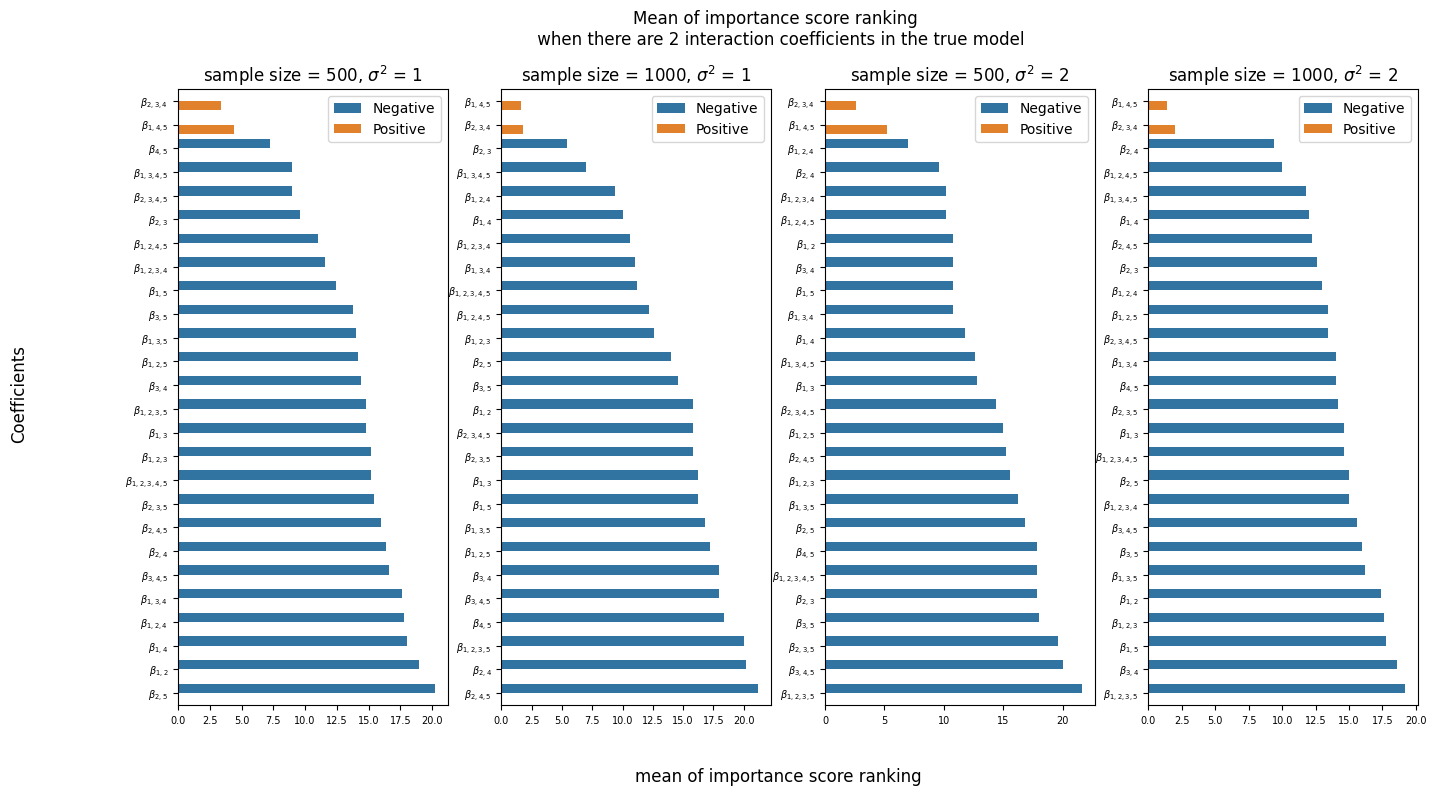

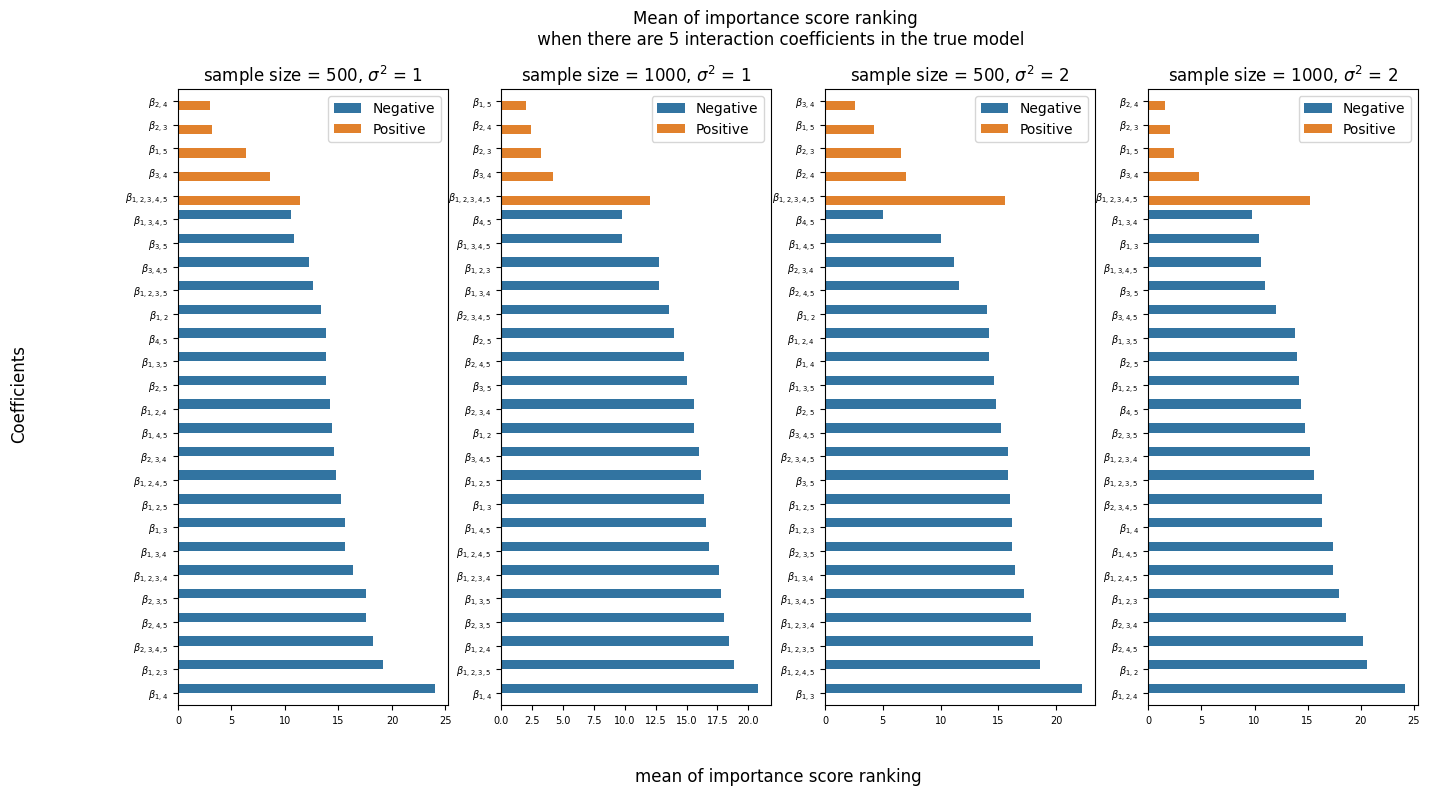

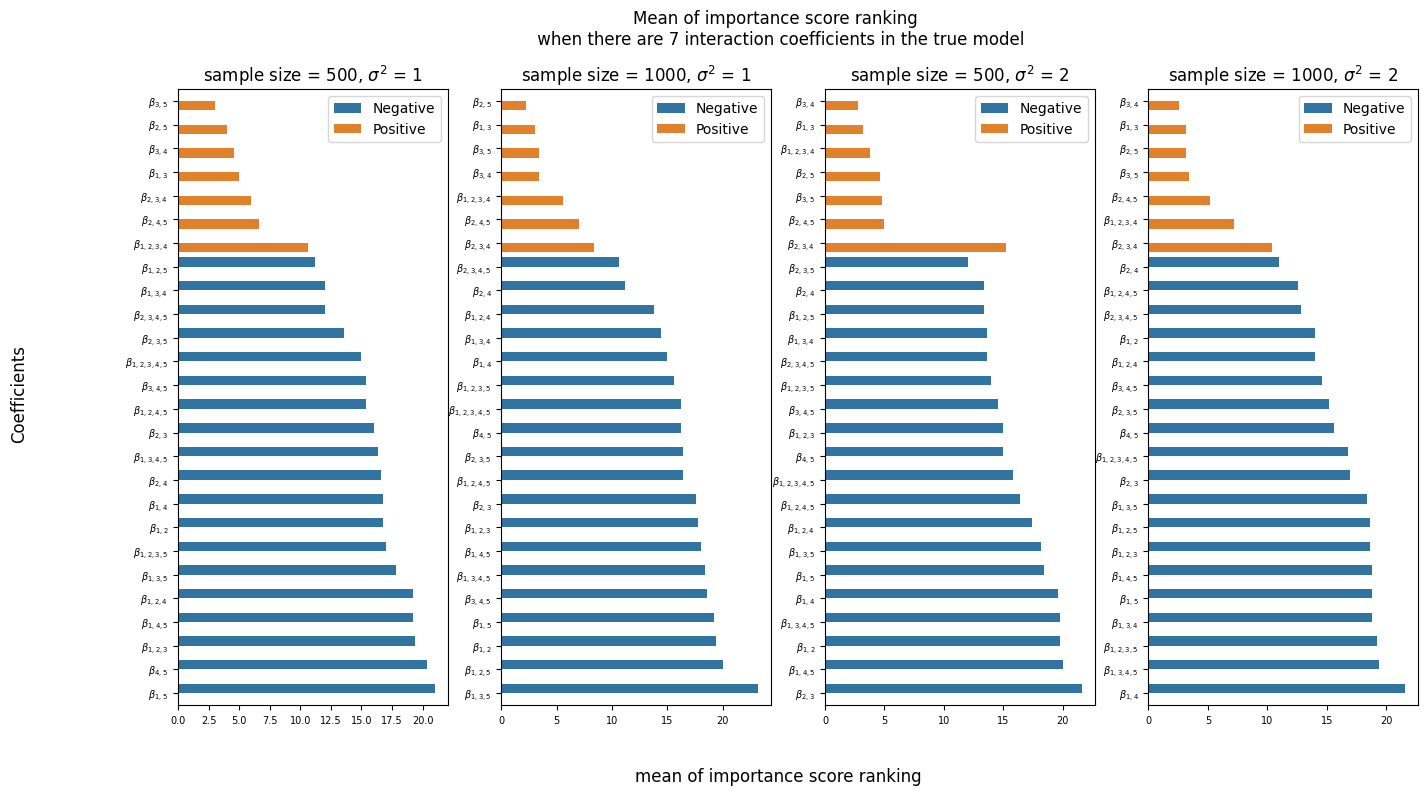

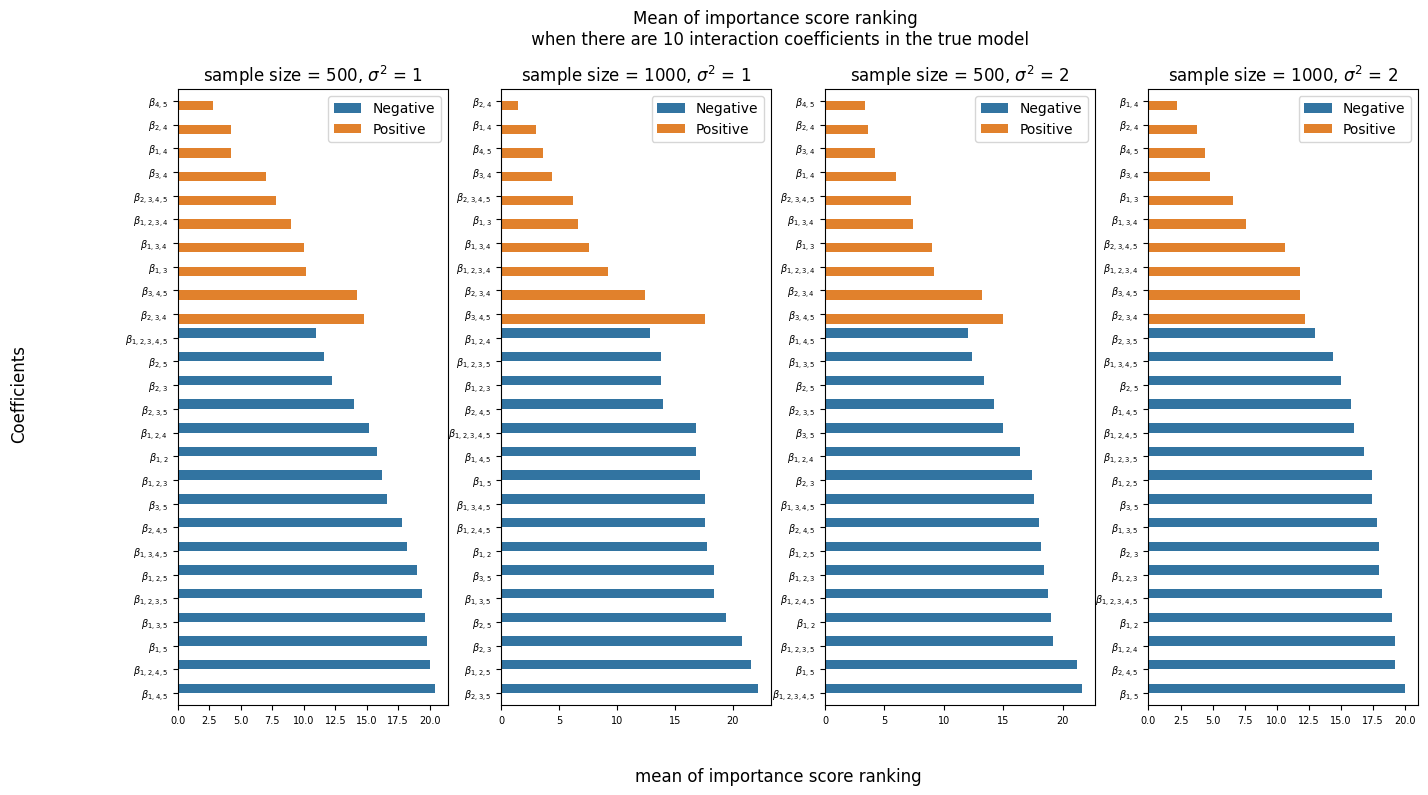

In [17]:
import seaborn as sns

def gen_and_save_plot(list_for_tests):
    fig, ax = plt.subplots(1, 4, sharey = False, figsize = (16,8))
    error_var = [1, 1, 2, 2]
    sample_size = [500, 1000, 500, 1000]
    num_interaction = list_for_tests[0].split("_")[1]
    for i, file_group_name in enumerate(list_for_tests):
        plot_df = return_plot_df(file_group_name)
        sns.barplot(plot_df, y = 'coefficients' ,x = 'mean_ranking', hue = 'true', orient = 'h', ax = ax[i])
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].set_xlabel(None)
        ax[i].legend(handles, ['Negative','Positive'])
        ax[i].set_title(f"sample size = {sample_size[i]}, ${latex(Symbol('sigma^2'))}$ = {error_var[i]}")
        ax[i].tick_params(axis='both', which='major', labelsize=7)
        ax[i].set_ylabel(None)
    fig.supylabel("Coefficients")
    fig.suptitle(f"Mean of importance score ranking \n when there are {num_interaction} interaction coefficients in the true model")
    fig.supxlabel("mean of importance score ranking")

    fig.savefig(f"../figures/num_interactions_{num_interaction}.png")

for num_interactions in [2, 5, 7, 10]:
    list_for_tests = [x for x in grouped_files.keys()  if (x.split('_')[1] ==f'{num_interactions}') & (float(x.split('_')[2]) < 2)]
    gen_and_save_plot(list_for_tests)